# Similarity-Based Link Prediction on Yelp Recommender

In [1]:
from random import choices, sample
from itertools import combinations
from collections import defaultdict
from tqdm import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import networkx as nx

from scipy.sparse import csc_matrix
from scipy.linalg import pinv
from scipy.sparse.linalg import inv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

In [2]:
t0 = datetime.now()

## Construct full network graph

Vertices = businesses (approximately 27K businesses)

Edges = There's an edge between $i$ and $j$ if the number of users are more than xx.

Note: See https://networkx.org/documentation/latest/reference/introduction.html#networkx-basics for `nx` package documentation

To determine an edge, look at the distribution of `num_users`.

Couldn't plot a histogram, probably because it's highly skewed

In [4]:
edge_df = pd.read_feather("data/business_edge_user_count.feather")

In [5]:
edge_df.head()

,b1,b2,num_users
0,0ZsqqzHu1HHkDdIKoivi5g,1An4DxtMmvvSe0HX4viRCA,4
1,0ZsqqzHu1HHkDdIKoivi5g,3YqUe2FTCQr0pPVK8oCv6Q,105
2,0ZsqqzHu1HHkDdIKoivi5g,3gXgILE2YWVidJDvVWBT6Q,6
3,0ZsqqzHu1HHkDdIKoivi5g,HpWi2CRJlxVCYKd8kS0X-A,4
4,0ZsqqzHu1HHkDdIKoivi5g,KP5OncF2jhT7_J1phHPPww,69


In [6]:
edge_df.describe()

,num_users
count,2.065332e+07
mean,2.321564e+00
std,3.913244e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,1.446000e+03


In [6]:
# sns.displot(data = edge_df, x = "num_users")
# plt.yscale('log')

In [7]:
for cutoff in [1, 5, 10, 20, 50, 100]:
    print(f"If cutoff = {cutoff}, there will be {len(edge_df[edge_df['num_users'] >= cutoff])} edges")

If cutoff = 1, there will be 20653315 edges
If cutoff = 5, there will be 1974099 edges
If cutoff = 10, there will be 588147 edges
If cutoff = 20, there will be 151273 edges
If cutoff = 50, there will be 18145 edges
If cutoff = 100, there will be 2471 edges


Since there's about 27K businesses (vertices), probably should take the cutoff = 5 for the existence of an edge

In [8]:
cutoff = 5
edge_subset = edge_df[edge_df['num_users'] >= cutoff]
edge_list = list(zip(*map(edge_subset.get, ['b1', 'b2', 'num_users'])))

In [9]:
G = nx.Graph()
G.add_weighted_edges_from(edge_list) # or use G.add_edges_from(edge_list) for unweifhted graph

In [22]:
print(f"Number of nodes in G: {len(G.nodes)}")
print(f"Number of edges in G: {len(G.edges)}")

Number of nodes in G: 20728
Number of edges in G: 1974099


In [26]:
deg_assort = nx.degree_assortativity_coefficient(G, x = 'out', y = 'out')
print(f"The network has degree assortativity: {deg_assort}")
print(f"Transitivity: {nx.transitivity(G)}")

The network has degree assortativity: -0.21032761437631706
Transitivity: 0.35343360655035805


Text(0, 0.5, 'Frequency')

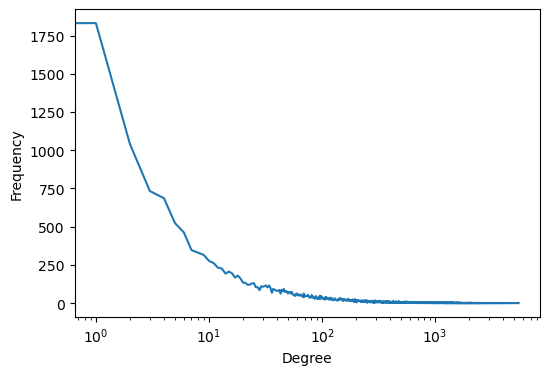

In [23]:
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(6, 4)) 
plt.plot(degrees, degree_freq)
plt.xscale('log')
# plt.loglog(degrees, degree_freq,'go-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')